## - The goal of this notebook is to take raw data and transfrom them to be ready for Yolo training 

The data are structured like so : 
```
dataset/
├── TRAIN/
│   ├── *.jpg          # Training images
│   └── *.xml          # Annotations (bounding boxes)
├── TEST/
│   ├── *.jpg          # Test images
│   └── *.xml          # Annotations (bounding boxes)
├── train_labels.csv   # Training labels in CSV format
└── test_labels.csv    # Test labels in CSV format
```

And our goal is to finally have :
```
dataset/
├── images/
│   ├── test/
│   │   └── *.jpg 
│   ├── train/
│   │   └── *.jpg 
├── labels/
│   │   └── *.txt 
│   ├── train/
│   │   └── *.txt
dataset.yaml
```

We will also divide our classes into 2 groups : species and diseases.  
Firstly, we will focus by designing a model that can predict the disease with a map50 > 0.8  
Later, we would implement a second model that could predict the species with a map50 > 0.8  
If we succeed to do so, we will combine both model to have a solution that can detect disease and species

# Step 1 : Cleaning

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("../../dataset/train_labels.csv")
df_test = pd.read_csv("../../dataset/test_labels.csv")

In [3]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,198,77,299,252
1,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,3,114,148,235
2,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,30,184,189,297
3,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,226,4,346,83
4,peach-and-leaf-stock-image-2809275.jpg,1300,1099,Peach leaf,237,479,527,810
...,...,...,...,...,...,...,...,...
8464,pddl-highlights-fig-1-bact-spot.jpg,1500,1000,Tomato leaf bacterial spot,17,204,271,433
8465,pddl-highlights-fig-1-bact-spot.jpg,1500,1000,Tomato leaf bacterial spot,279,180,459,489
8466,pddl-highlights-fig-1-bact-spot.jpg,1500,1000,Tomato leaf bacterial spot,588,267,931,740
8467,bacterialLeafSpot07-2jqdlmz.jpg,4000,3000,Tomato leaf bacterial spot,1065,512,2972,2157


In [4]:
df_train['class'] = (
    df_train['class']
    .str.replace(r'(?i)leaf', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.replace(r'_', ' ', regex=True)
    .str.strip()
)

In [5]:
plant_species = ['Apple', 'Bell Pepper', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Peach', 'Potato', 'Raspberry', 'Soyabean', 'Squash', 'Strawberry', 'Tomato']

In [6]:
def extract_species(text):
    """
    Extracting the plant species from the string

    Arg : text
    return : plant species
    """
    for plant in plant_species:
        if re.search(rf"\b{plant}\b", text, flags=re.IGNORECASE):
            return plant

def extract_disease(text):
    """
    Extracting the plant disease

    Arg : text
    return : plant desease
    """
    for plant in plant_species:
        text = re.sub(rf"\b{plant}\b", "", text, flags=re.IGNORECASE).strip()
    return text if text else "healthy"

In [7]:
df_train['species'] = df_train['class'].apply(extract_species)

In [8]:
df_train['disease'] = df_train['class'].apply(extract_disease)

In [9]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax,species,disease
0,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry,198,77,299,252,Cherry,healthy
1,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry,3,114,148,235,Cherry,healthy
2,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry,30,184,189,297,Cherry,healthy
3,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry,226,4,346,83,Cherry,healthy
4,peach-and-leaf-stock-image-2809275.jpg,1300,1099,Peach,237,479,527,810,Peach,healthy
...,...,...,...,...,...,...,...,...,...,...
8464,pddl-highlights-fig-1-bact-spot.jpg,1500,1000,Tomato bacterial spot,17,204,271,433,Tomato,bacterial spot
8465,pddl-highlights-fig-1-bact-spot.jpg,1500,1000,Tomato bacterial spot,279,180,459,489,Tomato,bacterial spot
8466,pddl-highlights-fig-1-bact-spot.jpg,1500,1000,Tomato bacterial spot,588,267,931,740,Tomato,bacterial spot
8467,bacterialLeafSpot07-2jqdlmz.jpg,4000,3000,Tomato bacterial spot,1065,512,2972,2157,Tomato,bacterial spot


In [10]:
df_train[df_train['height'] == 0]

,filename,width,height,class,xmin,ymin,xmax,ymax,species,disease
105,2f73110f80014a25a53f9551c94bf164.png.jpg,0,0,Corn Gray spot,58,92,525,386,Corn,Gray spot
5426,SouthernRustLeaf.png.jpg,0,0,Corn rust,1,142,664,349,Corn,rust
5926,ppth-friskop-1-corn-rust.png.jpg,0,0,Corn rust,78,1,566,192,Corn,rust
6817,southernrust1.png.jpg,0,0,Corn rust,55,1,430,628,Corn,rust


In [ ]:
from PIL import Image
from pathlib import Path

def fix_zero_dimensions(df, image_folder):
    """
    Replace 0 values in 'width' and 'height' with the actual image size.

    Parameters:
        df (pd.DataFrame): your dataframe with columns ['filename', 'width', 'height', ...]
        image_folder (str or Path): folder where images are stored
    """
    image_folder = Path(image_folder)

    for idx, row in df.iterrows():
        if row['width'] == 0 or row['height'] == 0:
            image_path = image_folder / row['filename']
            if image_path.exists():
                with Image.open(image_path) as img:
                    w, h = img.size
                    df.at[idx, 'width'] = w
                    df.at[idx, 'height'] = h
            else:
                print(f"Image not found: {image_path}")

    return df

# Usage
df_train = fix_zero_dimensions(df_train, "../../dataset/train")


In [12]:
df_train.iloc[105]

filename    2f73110f80014a25a53f9551c94bf164.png.jpg
width                                            525
height                                           395
class                                 Corn Gray spot
xmin                                              58
ymin                                              92
xmax                                             525
ymax                                             386
species                                         Corn
disease                                    Gray spot
Name: 105, dtype: object

## DISEASE EXPLORATION

In [13]:
df_train['disease'].value_counts()

disease
healthy                     4039
yellow virus                 787
late blight                  447
Septoria spot                412
blight                       360
early blight                 316
rust                         285
mold                         277
bacterial spot               266
Powdery mildew               251
spot                         249
mosaic virus                 225
Early blight                 195
Scab                         158
black rot                    125
Gray spot                     75
two spotted spider mites       2
Name: count, dtype: int64

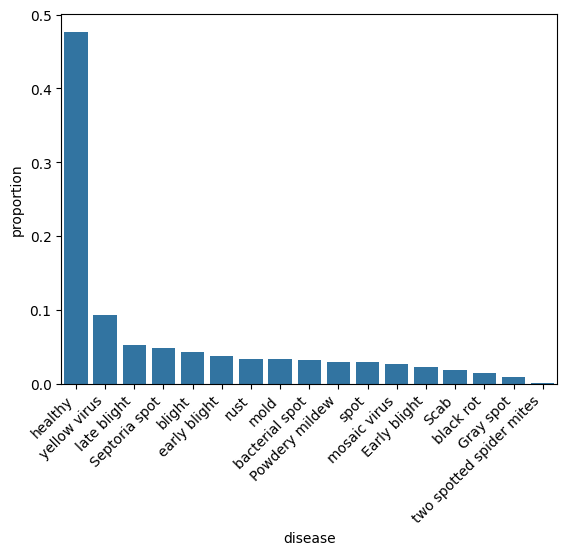

In [14]:
sns.barplot(df_train['disease'].value_counts(normalize=True))
plt.xticks(rotation=45, ha='right');

healthy --> 47.7%	Very dominant (almost half of dataset)  
yellow virus --> 9.3%	moderate  
most others --> 2–5%	rare  
two spotted spider mites --> 0.02%	extremely rare (potential outlier / noise)

In [15]:
df_disease = df_train[df_train['disease'] != 'two spotted spider mites']

In [16]:
df_disease['disease'].value_counts()

disease
healthy           4039
yellow virus       787
late blight        447
Septoria spot      412
blight             360
early blight       316
rust               285
mold               277
bacterial spot     266
Powdery mildew     251
spot               249
mosaic virus       225
Early blight       195
Scab               158
black rot          125
Gray spot           75
Name: count, dtype: int64

In [17]:
import os
import shutil
import pandas as pd
from pathlib import Path

In [18]:
# Paths
base_path = Path("../../dataset/disease")
images_train_path = base_path / "images" / "train"
labels_train_path = base_path / "labels" / "train"

# Create folders if they don't exist
images_train_path.mkdir(parents=True, exist_ok=True)
labels_train_path.mkdir(parents=True, exist_ok=True)

In [19]:
def convert_bbox_to_yolo(row):
    x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
    y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
    bbox_width = (row['xmax'] - row['xmin']) / row['width']
    bbox_height = (row['ymax'] - row['ymin']) / row['height']
    return x_center, y_center, bbox_width, bbox_height

In [20]:
diseases = df_disease['disease'].unique()
disease2idx = {disease: i for i, disease in enumerate(diseases)}
print(disease2idx)

{'healthy': 0, 'blight': 1, 'rust': 2, 'late blight': 3, 'mold': 4, 'early blight': 5, 'yellow virus': 6, 'mosaic virus': 7, 'bacterial spot': 8, 'Powdery mildew': 9, 'Gray spot': 10, 'Early blight': 11, 'Scab': 12, 'Septoria spot': 13, 'spot': 14, 'black rot': 15}


In [ ]:
for filename, group in df_disease.groupby("filename"):
    try:
        # Copy image
        src_image_path = Path("../../dataset/train") / filename
        dst_image_path = images_train_path / filename
        shutil.copy2(src_image_path, dst_image_path)

        # Create label file
        label_file = labels_train_path / (Path(filename).stem + ".txt")
        with open(label_file, "w") as f:
            for _, row in group.iterrows():
                cls_idx = disease2idx[row['disease']]
                x_center, y_center, w, h = convert_bbox_to_yolo(row)
                f.write(f"{cls_idx} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

    except FileNotFoundError:
        print(f"File not found, skipping: {filename}")
        continue


File not found, skipping: NCLB.jpg
File not found, skipping: early-blight-1.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg


- manually delete NLCB.xml because there is no jpg associated

In [24]:
target_count = df_disease['disease'].value_counts().max()  # e.g., 4039

for disease, group in df_disease.groupby("disease"):
    n_samples = len(group)
    n_to_add = target_count - n_samples
    if n_to_add <= 0:
        continue

    for i in range(n_to_add):
        row = group.iloc[i % n_samples]
        try:
            # Copy image with new name
            src_image_path = Path("../../dataset/train") / row['filename']
            new_image_name = f"{Path(row['filename']).stem}_dup{i}.jpg"
            dst_image_path = images_train_path / new_image_name
            shutil.copy2(src_image_path, dst_image_path)

            # Copy label with same new name
            src_label_path = labels_train_path / (Path(row['filename']).stem + ".txt")
            dst_label_path = labels_train_path / (Path(new_image_name).stem + ".txt")
            shutil.copy2(src_label_path, dst_label_path)

        except FileNotFoundError:
            print(f"File not found, skipping: {row['filename']}")
            continue


File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not found, skipping: powdery-mildew-on-squash-leaves.jpg
File not

KeyboardInterrupt: 

## SPECIES EXPLORATION

In [ ]:
sns.barplot(df_train['species'].value_counts(normalize=True))
plt.xticks(rotation=45, ha='right');

In [ ]:
df_train['species'].value_counts(normalize=True)

**If we are predecting species, we need to handle this imbalanced dataset to avoid the risk of overfitting**  

Here are our solution :  
- Use class weights during training.
- Add augmentation for underrepresented species.
- Use stratified splitting to keep proportions consistent.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# manage class imbalanced by balncing the weight of the loss function to penalize more the model for rare cases

classes = df_train['species'].unique()
weights = compute_class_weight('balanced', classes=classes, y=df_train['species'])
print(dict(zip(classes, weights)))

**We should now update the yaml fil with the correct weight for each class**  
Here is an example :
```
path: /content/drive/MyDrive/PlantDoc-Object-Detection
train: images/train
val: images/val

nc: 13
names:
  0: Tomato
  1: Blueberry
  2: Peach
  3: Potato
  4: Apple
  5: Bell Pepper
  6: Corn
  7: Raspberry
  8: Strawberry
  9: Grape
  10: Squash
  11: Soyabean
  12: Cherry

weights:
  0: 0.4     # Tomato
  1: 1.2     # Blueberry
  2: 1.5     # Peach
  3: 1.6     # Potato
  4: 1.4     # Apple
  5: 1.4     # Bell Pepper
  6: 1.5     # Corn
  7: 1.6     # Raspberry
  8: 1.7     # Strawberry
  9: 2.0     # Grape
  10: 2.1    # Squash
  11: 2.1    # Soyabean
  12: 2.5    # Cherry
  ```